In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import collections
from sklearn.preprocessing import LabelEncoder
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 500)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Define Constants
starting_elo_rating = 1500
elo_width = 500
k_factor = 20

In [3]:
#Define Functions for generating and updating rankings
def expected_result(elo_1, elo_2):
    expect_1 = 1.0 / (1 + 10 ** ((elo_2 - elo_1) / elo_width))
    return expect_1

def update_elo(winner_elo, loser_elo):
    expected_win = expected_result(winner_elo, loser_elo)
    change_in_elo = k_factor * (1 - expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

def end_of_season_update(elo_dict, teams_in_current_season):
    for team, elo in elo_dict.items():
        if team in teams_in_current_season:
            diff_from_mean = elo - starting_elo_rating
            new_elo = elo - diff_from_mean / 3.0
            elo_dict[team] = new_elo
    return elo_dict

In [5]:
#Load Data
header_columns = ["yyyymmdd", "# of Game", "Day of Week", "Visiting Team", "Visiting Team League", "Visiting Team Game Number",
                 "Home Team", "Home Team League", "Home Team Game Number", "Visiting Team Score", "Home Team Score", "Length of Game (Outs)",
                 "DayNight", "Completion of Game Information", "Forfeit Information", "Protest Information", "Park ID", "Attendance", "Time of Game (Mins)",
                 "Visiting line score", "Home line score", "Visiting AB", "Visiting Hits", "Visiting Doubles", "Visiting Triples", "Visiting HR",
                 "Visiting RBI", "Visiting Sac Hits", "Visiting Sac Flies", "Visiting HBP", "Visiting Walks", "Visiting Intentional Walks", "Visiting Strikeouts",
                 "Visiting Stolen Bases", "Visiting Caught Stealing", "Visiting grounded into DP", "Visiting awarded first on catcher's interference", 
                 "Visiting Left on Base", "Visiting Pitchers Used", "Visiting Individual Earned Runs", "Visiting Team Earned Runs", "Visiting Wild Pitches",
                 "Visiting Balks", "Visiting Putouts", "Visiting Assists", "Visiting Errors", "Visiting Passed Balls", "Visiting Double Plays", "Visiting Triple Plays",
                 "Home AB", "Home Hits", "Home Doubles", "Home Triples", "Home HR",
                 "Home RBI", "Home Sac Hits", "Home Sac Flies", "Home HBP", "Home Walks", "Home Intentional Walks", "Home Strikeouts",
                 "Home Stolen Bases", "Home Caught Stealing", "Home grounded into DP", "Home awarded first on catcher's interference", 
                 "Home Left on Base", "Home Pitchers Used", "Home Individual Earned Runs", "Home Team Earned Runs", "Home Wild Pitches",
                 "Home Balks", "Home Putouts", "Home Assists", "Home Errors", "Home Passed Balls", "Home Double Plays", "Home Triple Plays",
                 "Home Umpire ID", "Home Umpire", "1B Umpire ID", "1B Umpire", "2B Umpire ID", "2B Umpire", "3B Umpire ID", "3B Umpire",
                  "LF Umpire ID", "LF Umpire", "RF Umpire ID", "RF Umpire", "Visiting Manager ID", "Visiting Manager", "Home Manager ID", "Home Manager",
                  "Winning Pitcher ID", "Winning Pitcher", "Losing Pitcher ID", "Losing Pitcher", "Saving Pitcher ID", "Saving Pitcher", "Game Winning RBI Batter ID",
                  "Game Winning RBI Batter", "Visiting Starting Pitcher ID", "Visiting Starting Pitcher", "Home Starting Pitcher ID", "Home Starting Pitcher"]

for i in range(1, 10):
    header_columns.append("Visiting Player {} ID".format(i))
    header_columns.append("Visiting Player {} Name".format(i))
    header_columns.append("Visiting Player {} Defensive Position".format(i))
    
for i in range(1,10):
    header_columns.append("Home Player {} ID".format(i))
    header_columns.append("Home Player {} Name".format(i))
    header_columns.append("Home Player {} Defensive Position".format(i))
    
header_columns.append("Additional Information")
header_columns.append("Acquisition Information")



league_code = {
    "NA" : "National Association",
    "NL" : "National League",
    "AA" : "American Association",
    "UA" : "Union Association",
    "PL" : "Players League",
    "AL" : "American League",
    "FL" : "Federal League"
}

mapping_dict = {}
with open("TEAMABR.TXT", 'r') as f:
    for row in f:
        team_id, league, city, team, start_year, end_year = row.strip().replace('"',"").split(",")
        mapping_dict[team_id] = city + " " + team


In [36]:
current_df = pd.DataFrame()
for i in glob.glob("GL*.TXT"):
    int_df = pd.read_csv(i, index_col = None, header = None)
    current_df = pd.concat([current_df, int_df])

current_df.columns = header_columns    
    
def add_winning_team_col(row):
    if float(row["Home Team Score"]) > float(row["Visiting Team Score"]):
        return row["Home Team"]
    else:
        return row["Visiting Team"]

def add_losing_team_col(row):
    if float(row["Home Team Score"]) < float(row["Visiting Team Score"]):
        return row["Home Team"]
    else:
        return row["Visiting Team"]
    
current_df["Winning Team ID"] = current_df.apply(add_winning_team_col, axis = 1)
current_df["Winning Team Name"] = current_df["Winning Team ID"].map(mapping_dict)
current_df["Losing Team ID"] = current_df.apply(add_losing_team_col, axis = 1)
current_df["Losing Team Name"] = current_df["Losing Team ID"].map(mapping_dict)
current_df["Home Team League (Full)"] = current_df["Home Team League"].map(league_code)
current_df["Visiting Team League (Full)"] = current_df["Visiting Team League"].map(league_code)
current_df["Year"] = current_df["yyyymmdd"].astype(str).str[0:4]
current_df["Month"] = current_df["yyyymmdd"].astype(str).str[4:6]
current_df["Day"] = current_df["yyyymmdd"].astype(str).str[6:]
current_df["Home Team ELO"] = 0
current_df["Visiting Team ELO"] = 0
sorted_df = current_df.sort_values(["Year", "Month", "Day"], ascending= True)
print(sorted_df.head())

   yyyymmdd  # of Game Day of Week Visiting Team Visiting Team League  \
0  18710504          0         Thu           CL1                  NaN   
1  18710505          0         Fri           BS1                  NaN   
2  18710506          0         Sat           CL1                  NaN   
3  18710508          0         Mon           CL1                  NaN   
4  18710509          0         Tue           BS1                  NaN   

   Visiting Team Game Number Home Team Home Team League  \
0                          1       FW1              NaN   
1                          1       WS3              NaN   
2                          2       RC1              NaN   
3                          3       CH1              NaN   
4                          2       TRO              NaN   

   Home Team Game Number  Visiting Team Score  Home Team Score  \
0                      1                    0                2   
1                      1                   20               18   
2       

In [79]:
year_by_year_elo_dictionary = collections.defaultdict(dict)
years = sorted_df["Year"].unique()
teams_seen_last_year = []
for year in years:
    year_dict = {}
    last_year = int(year) - 1
    if last_year in year_by_year_elo_dictionary:
        last_year_normalized = end_of_season_update(year_by_year_elo_dictionary, teams_seen_last_year)
        teams_seen_last_year = []
        for k,v in last_year_normalized[int(year) - 1].items():
            year_dict[k] = v
    year_df = sorted_df[sorted_df["Year"] == year]
    for idx, row in year_df.iterrows():
        if row["Winning Team Name"] not in teams_seen_last_year:
            year_dict[row["Winning Team Name"]] = starting_elo_rating
            teams_seen_last_year.append(row["Winning Team Name"])
        if row["Losing Team Name"] not in teams_seen_last_year:
            year_dict[row["Losing Team Name"]] = starting_elo_rating
            teams_seen_last_year.append(row["Losing Team Name"])
        new_winning_elo, new_losing_elo = update_elo(year_dict[row["Winning Team Name"]], year_dict[row["Losing Team Name"]])
        year_dict[row["Winning Team Name"]] = new_winning_elo
        year_dict[row["Losing Team Name"]] = new_losing_elo
    

    drop_keys = [k for k in year_dict.keys() if k not in teams_seen_last_year]
    for keys in drop_keys:
        year_dict.pop(keys, None)
    year_by_year_elo_dictionary[int(year)] = year_dict
    
    

In [80]:
for year, ranking_dict in year_by_year_elo_dictionary.items():
    print(year, max(ranking_dict, key = ranking_dict.get))

1871 Boston Braves
1872 Boston Braves
1873 Boston Braves
1874 Boston Braves
1875 Boston Braves
1876 Chicago Cubs
1877 Boston Braves
1878 Boston Braves
1879 Providence Grays
1880 Chicago Cubs
1881 Chicago Cubs
1882 Chicago Cubs
1883 Boston Braves
1884 St. Louis Maroons
1885 New York Giants
1886 Chicago Cubs
1887 Philadelphia Phillies
1888 Brooklyn Dodgers
1889 Brooklyn Dodgers
1890 Chicago Cubs
1891 Boston Braves
1892 Boston Braves
1893 Pittsburgh Pirates
1894 Baltimore Orioles
1895 Baltimore Orioles
1896 Baltimore Orioles
1897 Boston Braves
1898 Boston Braves
1899 Brooklyn Dodgers
1900 Brooklyn Dodgers
1901 Pittsburgh Pirates
1902 Pittsburgh Pirates
1903 Boston Red Sox
1904 New York Giants
1905 New York Giants
1906 Chicago Cubs
1907 Chicago Cubs
1908 Chicago Cubs
1909 Pittsburgh Pirates
1910 Philadelphia Athletics
1911 Philadelphia Athletics
1912 Boston Red Sox
1913 Washington Senators
1914 Boston Braves
1915 Boston Red Sox
1916 New York Giants
1917 Chicago White Sox
1918 Cincinnati Re

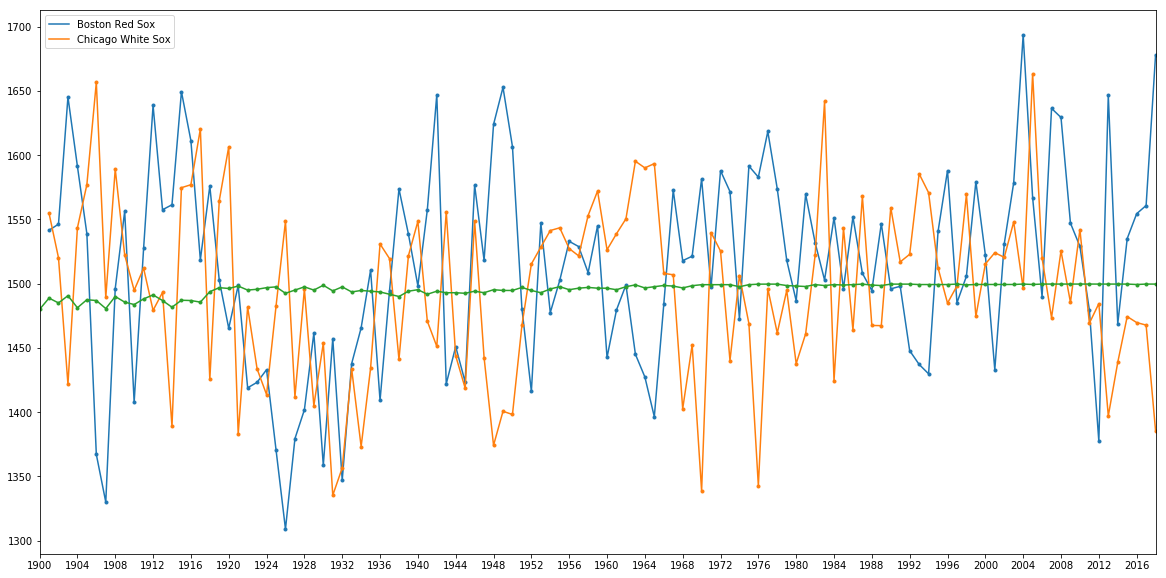

In [125]:
df = pd.DataFrame.from_dict(year_by_year_elo_dictionary, orient = 'index')
df.loc[1900:,["Boston Red Sox", "Chicago White Sox"]].plot(style = ".-", figsize = (20,10), xticks = range(1900, 2018,4))
df.loc[1900:].mean(axis =1).plot(style = ".-")
plt.show()

In [113]:
df.loc[1945:2000,].corr().loc["Boston Red Sox",].dropna()

Boston Braves             0.471717
Philadelphia Athletics   -0.109494
Cincinnati Reds           0.141192
Chicago Cubs             -0.049274
NaN                       0.148801
Pittsburgh Pirates        0.035808
St. Louis Cardinals      -0.115614
Baltimore Orioles         0.097735
New York Giants          -0.365235
Philadelphia Phillies    -0.032980
Brooklyn Dodgers          0.377192
Milwaukee Brewers        -0.287595
Washington Senators      -0.224537
Chicago White Sox        -0.543360
Cleveland Indians         0.104907
Detroit Tigers            0.012233
Boston Red Sox            1.000000
St.Louis Browns          -0.657914
New York Yankees          0.113007
Milwaukee Braves          0.364571
Kansas City Athletics    -0.116889
San Francisco Giants     -0.134711
Los Angeles Dodgers       0.011992
Los Angeles Angels       -0.165774
Minnesota Twins          -0.267217
Houston Colts             0.277051
New York Mets             0.288078
California Angels         0.242265
Atlanta Braves      